# 504 Batch Normalization

View more, visit my tutorial page: https://morvanzhou.github.io/tutorials/

My Youtube Channel: https://www.youtube.com/user/MorvanZhou

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import init
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

torch.manual_seed(1)    # reproducible
np.random.seed(1)

In [14]:
# Hyper parameters
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = torch.tanh
B_INIT = -0.2   # use a bad bias constant initializer

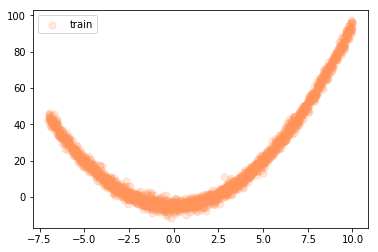

In [15]:
# training data
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise

# test data
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

train_x, train_y = torch.from_numpy(x).float(), torch.from_numpy(y).float()
test_x = Variable(torch.from_numpy(test_x).float())  # not for computing gradients
test_y = Variable(torch.from_numpy(test_y).float())

train_dataset = Data.TensorDataset(train_x, train_y)
train_loader = Data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,)

# show data
plt.scatter(train_x.numpy(), train_y.numpy(), c='#FF9359', s=50, alpha=0.2, label='train')
plt.legend(loc='upper left')

In [16]:
class Net(nn.Module):
    def __init__(self, batch_normalization=False):
        super(Net, self).__init__()
        self.do_bn = batch_normalization
        self.fcs = []
        self.bns = []
        self.bn_input = nn.BatchNorm1d(1, momentum=0.5)   # for input data

        for i in range(N_HIDDEN):               # build hidden layers and BN layers
            input_size = 1 if i == 0 else 10
            fc = nn.Linear(input_size, 10)
            setattr(self, 'fc%i' % i, fc)       # IMPORTANT set layer to the Module
            self._set_init(fc)                  # parameters initialization
            self.fcs.append(fc)
            if self.do_bn:
                bn = nn.BatchNorm1d(10, momentum=0.5)
                setattr(self, 'bn%i' % i, bn)   # IMPORTANT set layer to the Module
                self.bns.append(bn)

        self.predict = nn.Linear(10, 1)         # output layer
        self._set_init(self.predict)            # parameters initialization

    def _set_init(self, layer):
        init.normal_(layer.weight, mean=0., std=.1)
        init.constant_(layer.bias, B_INIT)

    def forward(self, x):
        pre_activation = [x]
        if self.do_bn: x = self.bn_input(x)     # input batch normalization
        layer_input = [x]
        for i in range(N_HIDDEN):
            x = self.fcs[i](x)
            pre_activation.append(x)
            if self.do_bn: x = self.bns[i](x)   # batch normalization
            x = ACTIVATION(x)
            layer_input.append(x)
        out = self.predict(x)
        return out, layer_input, pre_activation

In [17]:
nets = [Net(batch_normalization=False), Net(batch_normalization=True)]

print(*nets)    # print net architecture

Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (predict): Linear(in_features=10, out_features=1, bias=True)
) Net(
  (bn_input): BatchNorm1d(1, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=1, out_features=10, bias=True)
  (bn0): BatchNorm1d(10, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.5, af

In [18]:
opts = [torch.optim.Adam(net.parameters(), lr=LR) for net in nets]

loss_func = torch.nn.MSELoss()

Epoch:  0


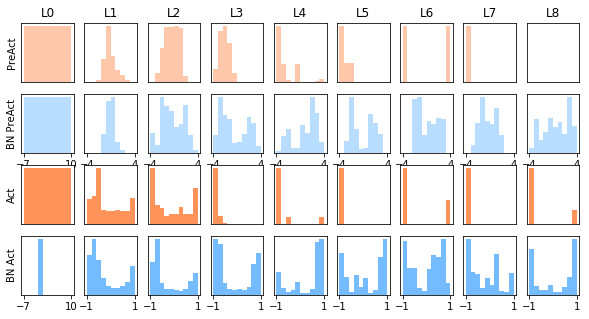

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


In [20]:
f, axs = plt.subplots(4, N_HIDDEN+1, figsize=(10, 5))
plt.ion()   # something about plotting
def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax,  ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0: p_range = (-7, 10);the_range = (-7, 10)
        else:p_range = (-4, 4);the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].data.numpy().ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5);ax_pa_bn.hist(pre_ac_bn[i].data.numpy().ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].data.numpy().ravel(), bins=10, range=the_range, color='#FF9359');ax_bn.hist(l_in_bn[i].data.numpy().ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]: a.set_yticks(());a.set_xticks(())
        ax_pa_bn.set_xticks(p_range);ax_bn.set_xticks(the_range)
        axs[0, 0].set_ylabel('PreAct');axs[1, 0].set_ylabel('BN PreAct');axs[2, 0].set_ylabel('Act');axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)
    
# training
losses = [[], []]  # recode loss for two networks
for epoch in range(EPOCH):
    print('Epoch: ', epoch)
    layer_inputs, pre_acts = [], []
    for net, l in zip(nets, losses):
        net.eval()              # set eval mode to fix moving_mean and moving_var
        pred, layer_input, pre_act = net(test_x)
        l.append(loss_func(pred, test_y).item())
        layer_inputs.append(layer_input)
        pre_acts.append(pre_act)
        net.train()             # free moving_mean and moving_var
    plot_histogram(*layer_inputs, *pre_acts)     # plot histogram

    for step, (b_x, b_y) in enumerate(train_loader):
        b_x, b_y = Variable(b_x), Variable(b_y)
        for net, opt in zip(nets, opts):     # train for each network
            pred, _, _ = net(b_x)
            loss = loss_func(pred, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()    # it will also learns the parameters in Batch Normalization
            
plt.ioff()

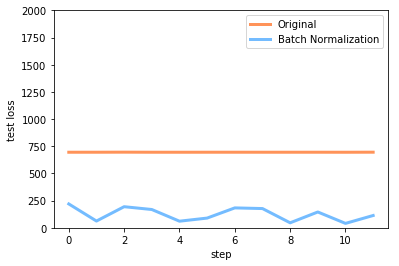

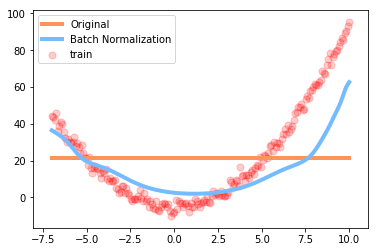

In [21]:
# plot training loss
plt.figure(2)
plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
plt.xlabel('step');plt.ylabel('test loss');plt.ylim((0, 2000));plt.legend(loc='best')

# evaluation
# set net to eval mode to freeze the parameters in batch normalization layers
[net.eval() for net in nets]    # set eval mode to fix moving_mean and moving_var
preds = [net(test_x)[0] for net in nets]
plt.figure(3)
plt.plot(test_x.data.numpy(), preds[0].data.numpy(), c='#FF9359', lw=4, label='Original')
plt.plot(test_x.data.numpy(), preds[1].data.numpy(), c='#74BCFF', lw=4, label='Batch Normalization')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='r', s=50, alpha=0.2, label='train')
plt.legend(loc='best')
plt.show()